In [1]:
# Load packages:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Aim of the analysis:

The aim of the analysis is to predict the probability that the majority of alerts are critical or not given the state of the train. To do so, several classification algorithms are applied to data and the best classifier is chosen according to performance measures.

2 versions will be develop:
- final user is someone external, someone which has restricted info on alerts that are occuring
- final user is the train_driver which has not the info on the criticality

In [2]:
# Load dataset:
df = pd.read_parquet('..//..//Final_dataset//TSR_040_daily_PDM.parquet', engine='fastparquet')
df = df[(df['Time'] > '2020-08-28') & (df['Time'] < '2023/01/25')]
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 64 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Time                   580 non-null    datetime64[ns]
 1   Source_mode            580 non-null    category      
 2   Source_711-083         580 non-null    int64         
 3   Source_711-084         580 non-null    int64         
 4   Name_mode              580 non-null    category      
 5   Name_710-131           580 non-null    int64         
 6   Name_710-132           580 non-null    int64         
 7   Name_710-135           580 non-null    int64         
 8   Name_710-170           580 non-null    int64         
 9   Name_711-083           580 non-null    int64         
 10  Name_711-084           580 non-null    int64         
 11  Type_mode              580 non-null    category      
 12  Type_PDM               580 non-null    int64         
 13  Type_

## Problem statement 1:

In this scenario the assumption is that who employ the algorithm has few info on log data, such as only how many alerts/warnings, speed, n. of services ... but no info on which specific event occurred/is occurring

In [3]:
# Drop columns out of interest:
#   -Time because it's not a time series and can't be used as a predictor
#   -Type_mode because every day assumes only 1 value of its 3 labels
#   -Complete_code due to data leakage (and assumption of the problem statement)
#   -Master because is not useful (compared to source or name)
#   -Criticality_ratio and 0,1 because are the same as Criticality_mode (which is the dependent variable)
#   -Count of each type of scheduled maintenances because some of them have only 1 value (the progressive count version of the variable has been created due to this)

#print(df.columns)
data = df.drop(columns=(['Time','Type_mode', 'Complete_code_mode',
       'Complete_code_2-19', 'Complete_code_5-1', 'Complete_code_5-10',
       'Complete_code_5-11', 'Complete_code_5-12', 'Complete_code_5-13',
       'Complete_code_5-14', 'Complete_code_5-15', 'Complete_code_5-16',
       'Complete_code_5-17', 'Complete_code_5-20', 'Complete_code_5-21',
       'Complete_code_5-3', 'Complete_code_5-31', 'Complete_code_5-32',
       'Complete_code_5-33', 'Complete_code_5-34', 'Complete_code_5-35',
       'Complete_code_5-36', 'Complete_code_5-5', 'Complete_code_5-7',
       'Complete_code_5-9', 'Complete_code_5-90', 'Complete_code_5-98',
       'Complete_code_5-99','Master_mode','Master_711-083','Master_Master Assente','Master_711-084', 'Criticality_ratio', 'Criticality_0', 'Criticality_1','R4_progr_count','RD_progr_count','RP_progr_count','RT_progr_count','VI_progr_count','VIS_progr_count']))
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Source_mode        580 non-null    category
 1   Source_711-083     580 non-null    int64   
 2   Source_711-084     580 non-null    int64   
 3   Name_mode          580 non-null    category
 4   Name_710-131       580 non-null    int64   
 5   Name_710-132       580 non-null    int64   
 6   Name_710-135       580 non-null    int64   
 7   Name_710-170       580 non-null    int64   
 8   Name_711-083       580 non-null    int64   
 9   Name_711-084       580 non-null    int64   
 10  Type_PDM           580 non-null    int64   
 11  Type_TRAIN_DRIVER  580 non-null    int64   
 12  Type_WARNING       580 non-null    int64   
 13  Speed_mean         580 non-null    float64 
 14  Criticality_mode   580 non-null    category
 15  Colour_mode        580 non-null    category
 16  Colour_a

### EDA

Firstly, relationships among variables are studied in order to develop the predictive model. Conditional distributions of X given the two classes of the Y are plotted and studied, correlation analysis is performed and interaction terms are studied as well



#### 1) Dependent variable Y --> Criticality_mode

In [4]:
# check the Y variable:
y_var = data['Criticality_mode']
print(y_var.value_counts())
print("\n")
print(f"How many times = 0?: {y_var.value_counts()[0]} --> {y_var.value_counts()[0]/len(y_var)}")
print(f"How many times = 1?: {y_var.value_counts()[1]} --> {y_var.value_counts()[1]/len(y_var)}")
y_var.value_counts(normalize=True)        # to obtain the same as above but easely

# there is strong imbalance between the 2 classes! 98% mode=0 vs 2% mode=1
# the minority class, which is the positive class 1, is the one the classifier has to predict and the majority class is the negative class 0

Criticality_mode
0    568
1     12
Name: count, dtype: int64


How many times = 0?: 568 --> 0.9793103448275862
How many times = 1?: 12 --> 0.020689655172413793


Criticality_mode
0    0.97931
1    0.02069
Name: proportion, dtype: float64

#### 2) Relationships between predictors X:

In order to evaluate the multicollinearity possibly existing if all covariates are included in the model, correlation measures are computed between all the X variables.

Perfect collinearity is expected between Source and Name or between Services and Total_KM as they represent the same info.

Depending on the type of variables, an appropriate association measure is used:
- pearson corr coeff for continuous-continuous
- spearman rank corr coeff for count-count and for continuous-count
- chi-square test for categorical-categorical and for categorical-count
- point biserial correlation (or t-test or kruskall wallis test) for continuous-categorical


In [5]:
# define X's types:
#print(data.columns)
x_contin = ['Speed_mean', 'Total_KM']
x_count = ['Source_711-083', 'Source_711-084', 'Name_710-131', 'Name_710-132', 'Name_710-135', 'Name_710-170', 'Name_711-083', 'Name_711-084', 'Type_PDM', 'Type_TRAIN_DRIVER', 'Type_WARNING', 'Colour_azzurro', 'Colour_giallo', 'Services', 'Sched_maint_progr', 'Corr_maint_progr']
x_cat = ['Source_mode', 'Name_mode', 'Colour_mode', 'Season']

PearsonRResult(statistic=0.47264431119174777, pvalue=1.2939629402989943e-33)


            Speed_mean  Total_KM
Speed_mean    1.000000  0.472644
Total_KM      0.472644  1.000000


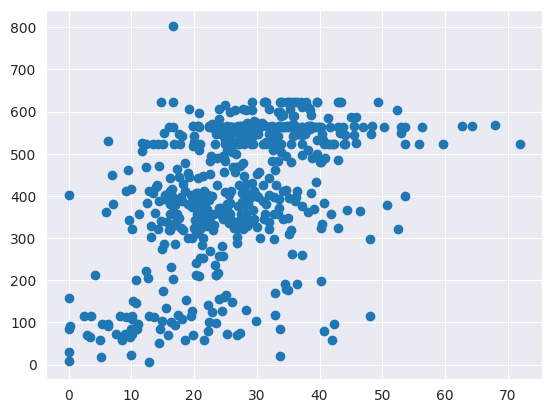

In [6]:
# between continuous variables:
print(scipy.stats.pearsonr(data[x_contin[0]], data[x_contin[1]]))
print("\n")
print(data[x_contin].corr())

plt.scatter(data[x_contin[0]], data[x_contin[1]])

# to note: 
#      p-value for testing non-correlation (H0 states the variables are not correlated while H1 they are correlated) --> p-value<0.05 so reject the null, which means they are correlated
#      pearson corr coeff ranges from 0 to 1

In [7]:
# between count variables:
spearman_corr_matrix = data[x_count].corr(method='spearman')
mask = np.triu(np.ones_like(spearman_corr_matrix, dtype=bool))
corr_matrix_truncated = spearman_corr_matrix.mask(mask)
corr_matrix_truncated
high_corr = corr_matrix_truncated.abs() > 0.8
corr_matrix_truncated[high_corr]

# to note: spearman rank coeff ranges from -1 to 1

# corr>0.8 in abs value are:
#      source_084-type_pdm
#      source_084-colour_giallo
#      source_084-colour_azzurro
#      type_pdm-colour_giallo
#      type_pdm-colour_azzurro
#      sched_maint-correct_maint

# conclusions:
#      pretty high corr between counts of source and counts of name
#      pretty high corr between counts of name and type_pdm
#      pretty high corr between counts of name and counts of colour

,Source_711-083,Source_711-084,Name_710-131,Name_710-132,Name_710-135,Name_710-170,Name_711-083,Name_711-084,Type_PDM,Type_TRAIN_DRIVER,Type_WARNING,Colour_azzurro,Colour_giallo,Services,Sched_maint_progr,Corr_maint_progr
Source_711-083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Source_711-084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_710-131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_710-132,NaN,0.853616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_710-135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_710-170,NaN,0.850255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_711-083,0.833433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_711-084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type_PDM,NaN,0.912488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type_TRAIN_DRIVER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# between categorical variables:
pairs = list(combinations(x_cat, 2))
print(pairs)
print("\n")

def perform_chi_square_test(data, pairs):
       contingency_table = pd.crosstab(data[pairs[0]], data[pairs[1]])
       chi2, p, dof, expected = chi2_contingency(contingency_table)
       n = contingency_table.sum().sum()  # total number of observations
       cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
       significant = p < 0.05  # 5% significance level
       return pairs, chi2, p, significant, cramers_v

for pair in pairs:
       print(perform_chi_square_test(data, pair))

# to note:
#      null hypothesis (H0) which states that there is no relation between the variables and alternative hypothesis (H1) which states there is a significant relationship between the two variables
#      cramer's V is used to measure the strength of association between two categorical variables and ranges from 0 to 1

# conclusions: just source_mode and name_mode are pretty much strong

[('Source_mode', 'Name_mode'), ('Source_mode', 'Colour_mode'), ('Source_mode', 'Season'), ('Name_mode', 'Colour_mode'), ('Name_mode', 'Season'), ('Colour_mode', 'Season')]


(('Source_mode', 'Name_mode'), 237.20306344669402, 3.0548472112864503e-49, True, 0.6395082478326798)
(('Source_mode', 'Colour_mode'), 20.58412763394469, 5.706730118260698e-06, True, 0.18838756655081862)
(('Source_mode', 'Season'), 8.206841785833959, 0.04192484464442746, True, 0.1189526259355173)
(('Name_mode', 'Colour_mode'), 64.3257334996882, 1.5464396990647363e-12, True, 0.3330261807552492)
(('Name_mode', 'Season'), 51.30039123466347, 7.3683260242749535e-06, True, 0.1717060961882175)
(('Colour_mode', 'Season'), 20.6171298974358, 0.0001264187545502172, True, 0.18853852573210106)


In [9]:
# between continuous and count variables:
x_count_contin = x_count+x_contin
print(x_count_contin)
spearman_corr_matrix = data[x_count_contin].corr(method='spearman')
mask = np.triu(np.ones_like(spearman_corr_matrix, dtype=bool))
corr_matrix_truncated = spearman_corr_matrix.mask(mask)
corr_matrix_truncated
#high_corr = corr_matrix_truncated.abs() > 0.8
#corr_matrix_truncated[high_corr]

# conclusions: any strong association between the continuous and counts variables

['Source_711-083', 'Source_711-084', 'Name_710-131', 'Name_710-132', 'Name_710-135', 'Name_710-170', 'Name_711-083', 'Name_711-084', 'Type_PDM', 'Type_TRAIN_DRIVER', 'Type_WARNING', 'Colour_azzurro', 'Colour_giallo', 'Services', 'Sched_maint_progr', 'Corr_maint_progr', 'Speed_mean', 'Total_KM']


,Source_711-083,Source_711-084,Name_710-131,Name_710-132,Name_710-135,Name_710-170,Name_711-083,Name_711-084,Type_PDM,Type_TRAIN_DRIVER,Type_WARNING,Colour_azzurro,Colour_giallo,Services,Sched_maint_progr,Corr_maint_progr,Speed_mean,Total_KM
Source_711-083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Source_711-084,0.347475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_710-131,0.578009,0.188588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_710-132,0.280903,0.853616,0.160174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_710-135,0.712629,0.361417,0.265437,0.291670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_710-170,0.318326,0.850255,0.189344,0.594318,0.312111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_711-083,0.833433,0.280960,0.234917,0.246153,0.505034,0.232850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name_711-084,0.327048,0.793421,0.116272,0.604109,0.342260,0.559687,0.299227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type_PDM,0.657052,0.912488,0.358898,0.773241,0.546620,0.779577,0.551489,0.745465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type_TRAIN_DRIVER,0.100336,0.212899,0.124196,0.135714,0.117009,0.167625,0.063243,0.251244,0.188082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# between categorical and count variables:
x_cat_count = x_cat+x_count
#print(x_cat_count)
pairs = list(combinations(x_cat_count, 2))
#print(pairs)
print("\n")
for pair in pairs:
       if perform_chi_square_test(data, pair)[4]>0.7:
              print(perform_chi_square_test(data, pair))

# conclusions:
#      strong association between season and sched_maint
#      pretty high association between source_mode and type_pdm , source_mode and colour_azzurro, colour_mode and type_pdm



(('Source_mode', 'Source_711-084'), 329.35391465677174, 7.902755736036667e-08, True, 0.753559272383025)
(('Source_mode', 'Type_PDM'), 320.07997251425826, 0.0003542732443433861, True, 0.7428741626791898)
(('Source_mode', 'Colour_azzurro'), 290.5938294509723, 3.604447687708613e-05, True, 0.7078303779020697)
(('Colour_mode', 'Source_711-084'), 292.0508937227202, 6.164761105487041e-05, True, 0.709602722415763)
(('Colour_mode', 'Type_PDM'), 330.82483392080917, 7.61585220379184e-05, True, 0.7552401238619744)
(('Season', 'Sched_maint_progr'), 1315.4288118240981, 2.2196022235483157e-248, True, 0.8694789071701794)
(('Source_711-084', 'Name_710-132'), 27940.808841687412, 0.0, True, 0.7158821990022276)
(('Source_711-084', 'Name_711-084'), 26812.044354063823, 0.0, True, 0.7166873072951719)
(('Source_711-084', 'Type_TRAIN_DRIVER'), 3299.8590603237344, 6.534447503458957e-62, True, 0.7542819216295692)
(('Name_710-131', 'Type_PDM'), 17928.633379775125, 2.6912825213988773e-98, True, 0.723825019374547

['Source_mode', 'Name_mode', 'Colour_mode', 'Season']
['Speed_mean', 'Total_KM']
Source_mode and Speed_mean: SignificanceResult(statistic=0.09588572774833498, pvalue=0.020911636542936343)
Source_mode and Total_KM: SignificanceResult(statistic=0.0742921104621456, pvalue=0.07380790867656385)
Colour_mode and Speed_mean: SignificanceResult(statistic=-0.12038995689862397, pvalue=0.0036879675037419565)
Colour_mode and Total_KM: SignificanceResult(statistic=-0.092265826667594, pvalue=0.02628309366670938)


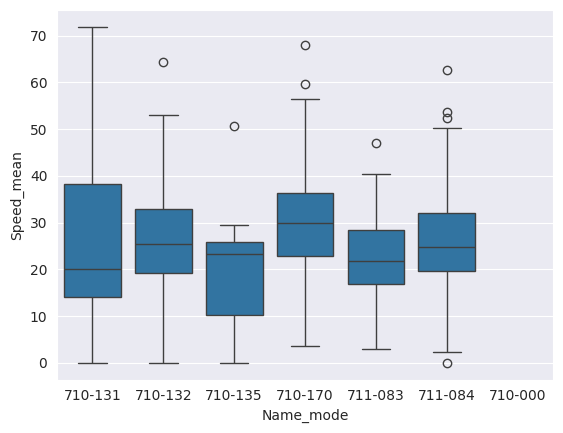

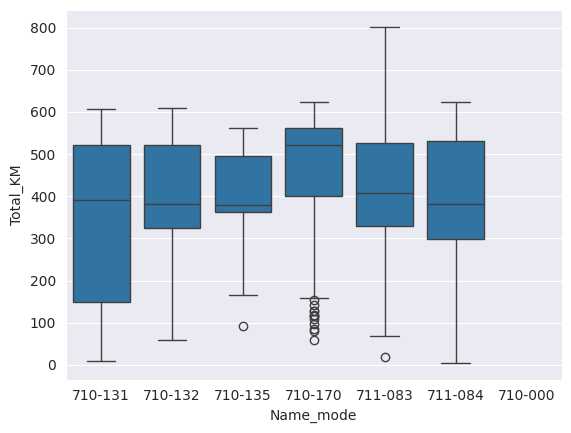

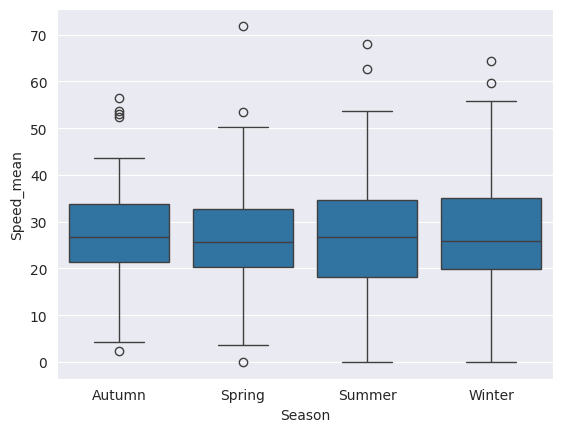

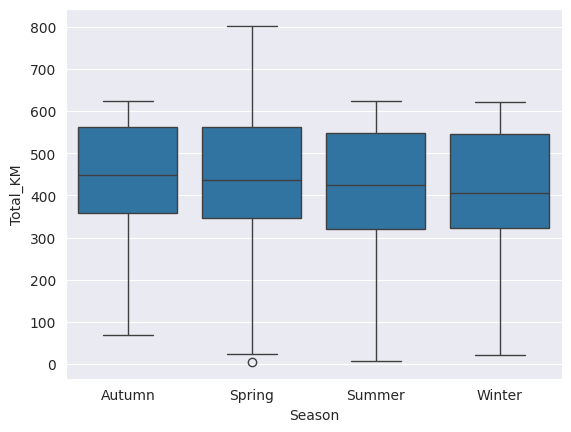

In [11]:
# between continuous and categorical variables:
# a) binary --> point biserial correlation:
print(x_cat)
print(x_contin)
source_numeric = np.where(data[x_cat[0]] == '711-083', 0, 1)
colour_numeric = np.where(data[x_cat[2]] == 'azzurro', 0, 1)
print(f"Source_mode and Speed_mean: {pointbiserialr(data[x_contin[0]], source_numeric)}")
print(f"Source_mode and Total_KM: {pointbiserialr(data[x_contin[1]], source_numeric)}")
print(f"Colour_mode and Speed_mean: {pointbiserialr(data[x_contin[0]], colour_numeric)}")
print(f"Colour_mode and Total_KM: {pointbiserialr(data[x_contin[1]], colour_numeric)}")

# to note: point biserial correlation ranges from -1 to 1
# conclusion: any association

# b) categorical nominal --> boxplots
sns.boxplot(x=data[x_cat[1]], y=data[x_contin[0]], data=data)
plt.show()
sns.boxplot(x=data[x_cat[1]], y=data[x_contin[1]], data=data)
plt.show()
sns.boxplot(x=data[x_cat[3]], y=data[x_contin[0]], data=data)
plt.show()
sns.boxplot(x=data[x_cat[3]], y=data[x_contin[1]], data=data)
plt.show()

# conclusions: any particular changes for any pairs

#### 3) Draft of relationship between Y and numerical variables X

2 ways:
- association measures to get an idea of association between Y and X variables --> needed for classifiers which can't directly handle curse of dimensionality (logistic, knn, svm), while trees and ensemble methods implicity perform feature selection when deciding which predictor to use for each split
- significance and impact of each single X on Y --> it can be done only for logistic regression

In order to understand which are the candidates to be predictors of a logistic regression, marginal correlation coefficients can be used for exploratory analysis to seek candidates predictors, which means fitting a marginal model for each predictor. The point is that if a predictor results here NOT significant, it is very unlikely that it can impact in the multiple model (bog model), but on the other hand, if it is significant it could not be the same in the big model!

To note that here a bias is arbitrary included as the imbalamce problem is not handled and the dataset is not splitted into train and test

['Source_mode', 'Name_mode', 'Colour_mode', 'Season']
['Speed_mean', 'Total_KM']
['Source_711-083', 'Source_711-084', 'Name_710-131', 'Name_710-132', 'Name_710-135', 'Name_710-170', 'Name_711-083', 'Name_711-084', 'Type_PDM', 'Type_TRAIN_DRIVER', 'Type_WARNING', 'Colour_azzurro', 'Colour_giallo', 'Services', 'Sched_maint_progr', 'Corr_maint_progr']


(('Source_711-083', 'Criticality_mode'), 106.02844990168933, 0.7357558630896748, False, 0.42756013874575816)
(('Source_711-084', 'Criticality_mode'), 222.65020679633358, 0.1892799851243922, False, 0.6195802344250745)
(('Name_710-131', 'Criticality_mode'), 59.411502686150556, 0.4604978212112969, False, 0.32005253525155714)
(('Name_710-132', 'Criticality_mode'), 112.57891365285732, 0.09296939270188673, False, 0.4405696031997068)
(('Name_710-135', 'Criticality_mode'), 22.14637026445207, 0.998865823854523, False, 0.19540572409137863)
(('Name_710-170', 'Criticality_mode'), 121.49013561425528, 0.10308298327899207, False, 0.4576742849003654)
(('N

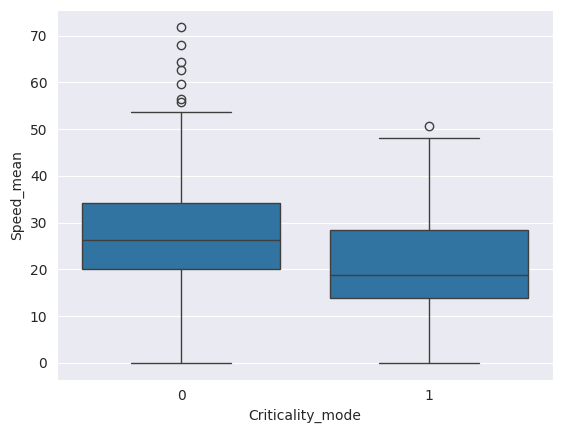

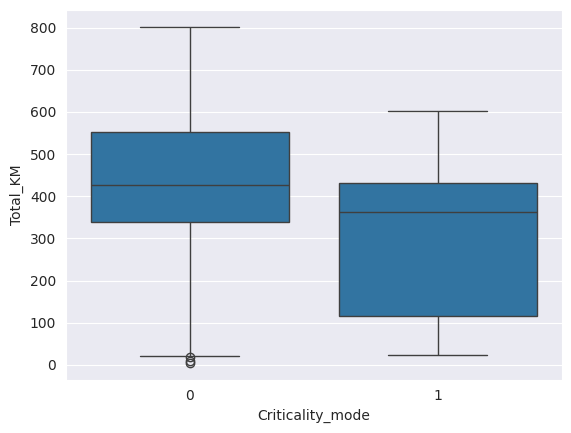

In [12]:
# 1) association between Y and each X:
print(x_cat)
print(x_contin)
print(x_count)
y = ['Criticality_mode']

# a) Y and count variables:
x_count_y = x_count+y
pairs = list(combinations(x_count_y, 2))
print("\n")
for pair in pairs:
       if 'Criticality_mode' in pair:
              print(perform_chi_square_test(data, pair))

# conclusion: more than weak association between Source_711-084, Type_PDM, Colour_azzurro


# b) Y and categorical variables:
x_cat_y = x_cat+y
pairs = list(combinations(x_cat_y, 2))
print("\n")
for pair in pairs:
       if 'Criticality_mode' in pair:
              print(perform_chi_square_test(data, pair))

# conclusion: more than weak association between Colour_mode


# c) Y and continuous variables --> no point biserial corr due to huge imbalance:
sns.boxplot(x=data['Criticality_mode'], y=data['Speed_mean'], data=data)
plt.show()
sns.boxplot(x=data['Criticality_mode'], y=data['Total_KM'], data=data)
plt.show()

# conclusion: it seems there are more difference between speed_mean while almost any between total_km

In [13]:
# 2) marginal effects:

# a) change name to convert - in _ due to syntax issues:
data = data.rename(columns={'Source_711-083': 'Source_711_083'})
data = data.rename(columns={'Source_711-084': 'Source_711_084'})
data = data.rename(columns={'Name_710-131': 'Name_710_131'})
data = data.rename(columns={'Name_710-132': 'Name_710_132'})
data = data.rename(columns={'Name_710-135': 'Name_710_135'})
data = data.rename(columns={'Name_710-170': 'Name_710_170'})
data = data.rename(columns={'Name_711-083': 'Name_711_083'})
data = data.rename(columns={'Name_711-084': 'Name_711_084'})

# b) dependent and independent variables:
x = data.drop(columns=['Criticality_mode','Name_mode'], axis=1)     # name_mode is excluded due to singularity matrix!
print(x.info())
y = data['Criticality_mode'].astype('int64')    # convert into numerical dummy variable to be processed by the function

print("\n")
print(type(y))
for i in x:
    print(type(x[i]))
    print(x[i].shape)
print("\n")
print(y.shape)

# c) iterate over all X:
for i in x.columns:  # Iterate over column names
    if data[i].dtype == 'category':  # Check if the column is categorical to use notation "C()" which is the way to handle categorical variable --> it automatically exclude a category and use it as reference category
        formula = f'y ~ C({i})'
        print(f"Criticality_mode ~ {i}")
        model = smf.logit(formula, data=data)
        results = model.fit(disp=True)
        print(results.summary())
        print("\n")
    else:
        formula = f'y ~ {i}'
        print(f"Criticality_mode ~ {i}")
        model = smf.logit(formula, data=data)
        results = model.fit(disp=True)
        print(results.summary())
        print("\n")
        
# conclusion:
#   p-value>0.05 for Source_711_083, Name_710_131, Name_710_135, (gli altri name un po' al limite), Type_TRAIN_DRIVER, Type_WARNING, Speed_mean, Colour_mode (Maximum number of iterations has been exceeded and Possibly complete quasi-separation), Colour_giallo, 2 su 3 Season (Possibly complete quasi-separation), Services, Corr_maint_progr
#   p-value<0.05 for Source_mode, Source_711_084, Name_710_132, Name_710_170, Name_711_083, Name_711_084, Type_PDM, Colour_azzurro, Total_KM, Sched_maint_progr

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Source_mode        580 non-null    category
 1   Source_711_083     580 non-null    int64   
 2   Source_711_084     580 non-null    int64   
 3   Name_710_131       580 non-null    int64   
 4   Name_710_132       580 non-null    int64   
 5   Name_710_135       580 non-null    int64   
 6   Name_710_170       580 non-null    int64   
 7   Name_711_083       580 non-null    int64   
 8   Name_711_084       580 non-null    int64   
 9   Type_PDM           580 non-null    int64   
 10  Type_TRAIN_DRIVER  580 non-null    int64   
 11  Type_WARNING       580 non-null    int64   
 12  Speed_mean         580 non-null    float64 
 13  Colour_mode        580 non-null    category
 14  Colour_azzurro     580 non-null    int64   
 15  Colour_giallo      580 non-null    int64   
 16  Season  

/home/jupyter-giulia/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
'''
# extra) singularity when x=Name_mode:
model = smf.logit('y ~ C(Name_mode)', data=data)  # Use the formula in the model
results = model.fit()
print(results.summary())

# possible problem: Insufficient Data Variation
'''

"\n# extra) singularity when x=Name_mode:\nmodel = smf.logit('y ~ C(Name_mode)', data=data)  # Use the formula in the model\nresults = model.fit()\nprint(results.summary())\n\n# possible problem: Insufficient Data Variation\n"

#### 4) Interaction terms

3 possible interaction terms are studied to understand if they can improve the prediction of the models:
- type_pdm with colour_giallo
- sched_maint with correct_maint
- total_KM and type_PDM in order to handle with multimodal of total km

Since decision trees are able to seek also interaction terms between predictors, this step is useful for the logistic model only

In [15]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
x_int_1 = data[['Type_PDM','Colour_giallo']]
x_int_2 = data[['Sched_maint_progr','Corr_maint_progr']]
x_int_3 = data[['Total_KM','Type_PDM']]
inter_pdm_giallo = poly.fit_transform(x_int_1)
inter_sched_corr = poly.fit_transform(x_int_2)
inter_type_km = poly.fit_transform(x_int_3)

model = smf.logit('y ~ inter_pdm_giallo', data=data)
results = model.fit()
print(results.summary())

model = smf.logit('y ~ inter_sched_corr', data=data)
results = model.fit()
print(results.summary())

model = smf.logit('y ~ inter_type_km', data=data)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.041668
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  580
Model:                          Logit   Df Residuals:                      576
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Sep 2024   Pseudo R-squ.:                  0.5863
Time:                        13:51:51   Log-Likelihood:                -24.168
converged:                       True   LL-Null:                       -58.412
Covariance Type:            nonrobust   LLR p-value:                 8.987e-15
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.8430      0.640     -1.316      0.188      -2.098       0.412
i

Results of EDA:
- about multicollinearity between variables that represent the same info (source-name, services-total km): source and tot km have been chosen to be used while name and services will be dropped from X vector and 
- about which version to use (count or mode for source, name, colour): count for colour and source have been chosen to be used
- potential multicollinearity issue between predictors: it seems there could be this problem for source and type_pdm and colour, sched maint and corr maint, season and sched maint
- only interaction between total_km and type_pdm will be considered in the model

In [16]:
# drop X variables not used into models:
print(data.info())
data2 = data.drop(columns=['Source_mode','Name_mode','Name_710_131','Name_710_132','Name_710_135','Name_710_170','Name_711_083','Name_711_084','Colour_mode', 'Services', 'Season'])
print(data2.info())

# check again ranges of variables kept:
for i in data2.columns:
    print(data2[i].describe())
    print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Source_mode        580 non-null    category
 1   Source_711_083     580 non-null    int64   
 2   Source_711_084     580 non-null    int64   
 3   Name_mode          580 non-null    category
 4   Name_710_131       580 non-null    int64   
 5   Name_710_132       580 non-null    int64   
 6   Name_710_135       580 non-null    int64   
 7   Name_710_170       580 non-null    int64   
 8   Name_711_083       580 non-null    int64   
 9   Name_711_084       580 non-null    int64   
 10  Type_PDM           580 non-null    int64   
 11  Type_TRAIN_DRIVER  580 non-null    int64   
 12  Type_WARNING       580 non-null    int64   
 13  Speed_mean         580 non-null    float64 
 14  Criticality_mode   580 non-null    category
 15  Colour_mode        580 non-null    category
 16  Colour_a

### Analysis --> tuning parameters, fit, model evaluation:

Given the set of predictors that comes from EDA, the following classifier will be considered: KNN, LDA, SVM, logistic, pruned decision tree, random forest, bagging, boosting

The imbalance issue can be solved in 2 ways:
- by applying techniques that tries to rebalance the dataset --> oversampling techniques will be applied to create new instances of the minority class: SMOTE and ADASYN
- by doing the so called "threshold moving" --> cut off point is optimized on the imbalanced dataset

Each classifier will be fitted on:
- imbalanced dataset
- rebalanced with SMOTE
- rebalanced with ADASYN
- imbalanced dataset + optimal threshold

Tuning the parameters of each classifier and the parameters of SMOTE/ADASYN will be performed

Steps are:
- for each classifier find the "dataset" or threshold for which it performs better
- find the overall best classifier (the best of the bests)

and to do so, the following performance measures will be used: F1-score, sensitivity, specificity and AUC

In order to perform all, a pipeline for each classifier will be build and implement

In [17]:
# Split into train and test set --> 70% and 30%:
x = data2.drop(columns=['Criticality_mode'])
y = data2['Criticality_mode']
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                   random_state=123,        # to reply results
                                   test_size=0.3,           # 70% train and 30% test
                                   shuffle=True)            # to shuffle data (otherwise it takes the first 70% of obs as train set --> no random)

# Standardize the dataset
scaler = StandardScaler()
x_train_sd = scaler.fit_transform(x_train)
x_test_sd = scaler.transform(x_test)            # .transform for test set in order to applies the same transformation from the training set

#### a) Logistic regression

Lasso (penalty term l1) is implemented inside logistic regression algorithm and parameter "C" is tuned

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, make_scorer, roc_curve

#### a1) Imbalanced dataset:

Tuning parameter:
F1 score max: 0.3
C tuned: 0.15000000000000002

Model fitted:
F1 Score: 0.000000
Sensitivity (Recall): 0.000000
Specificity: 1.000000
AUC: 0.983432
Features used in the model:
Feature 1 (Coefficient: 0.0082)
Feature 2 (Coefficient: -0.0136)
Feature 3 (Coefficient: 0.0000)
Feature 4 (Coefficient: 0.0000)
Feature 5 (Coefficient: 0.0000)
Feature 6 (Coefficient: 0.0000)
Feature 7 (Coefficient: -0.1362)
Feature 8 (Coefficient: 0.1306)
Feature 9 (Coefficient: -0.0006)
Feature 10 (Coefficient: 0.0000)
Feature 11 (Coefficient: -0.1061)


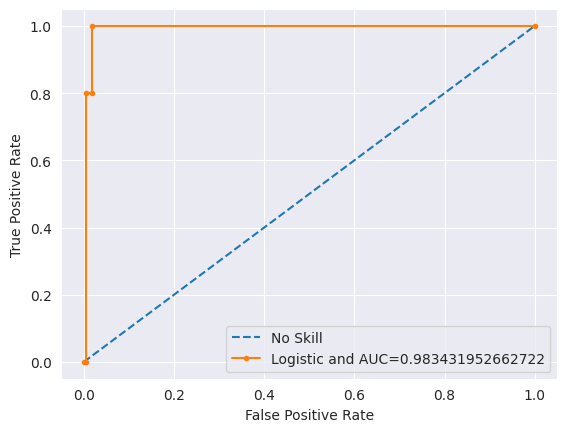

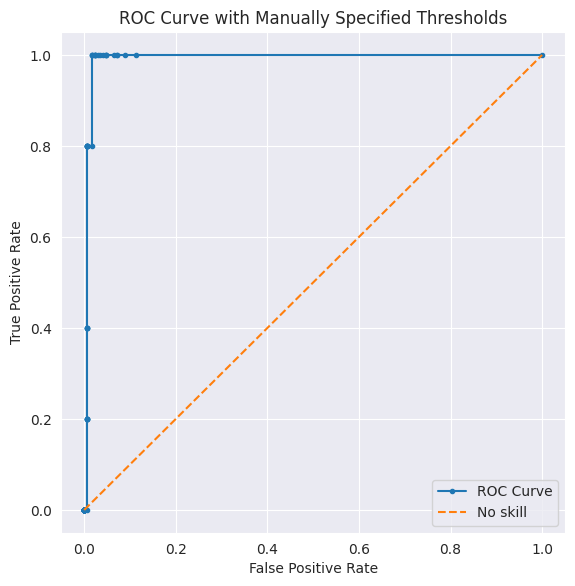

In [19]:
# a) Define the logistic regression model with L1 penalty
logistic = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# b) Define the parameter grid for tuning the regularization parameter C
param_grid = {'C': np.arange(0.05, 2, 0.05)}
# and use F1 score as metric for tuning
f1_scorer = make_scorer(f1_score)

# c) Perform GridSearchCV to find the best parameter based on F1 score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
grid_search = GridSearchCV(logistic, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1, refit=False)
result_tuning = grid_search.fit(x_train, y_train)
# check value of f1 score and C:
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
tuned_par = list(result_tuning.best_params_.values())[0]
print(f"C tuned: {tuned_par}")

# d) fit logistic with tuned parameter
logistic_tuned = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=tuned_par)
log_fit = logistic_tuned.fit(x_train, y_train)

# e) Predict on the test set
y_prob = log_fit.predict_proba(x_test)[:, 1]    # predicted prob for positive class
y_pred = log_fit.predict(x_test)

# f) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# g) Print out the results
print("\nModel fitted:")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

coefficients = log_fit.coef_[0]
non_zero_coefficients = coefficients != 0
used_features = np.array(non_zero_coefficients)

print("Features used in the model:")
for i, is_used in enumerate(non_zero_coefficients):
    if is_used:
        print(f"Feature {i+1} (Coefficient: {coefficients[i]:.4f})")
    else:
        print(f"Feature {i+1} (Coefficient: {coefficients[i]:.4f})")

# h) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic and AUC='+str(correct_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [20]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

6
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### a2) SMOTE rebelanced dataset:

Tuning parameter:
F1 score max: 0.49333333333333335
SMOTE k neighbors: 3
Imbalance ratio: 0.4
Logistic C: 0.25
Criticality_mode
0    399
1    159
Name: count, dtype: int64

Model fitted:
F1 Score: 0.769231
Sensitivity (Recall): 1.000000
Specificity: 0.982249
AUC: 0.985799
Features used in the model:
Feature 1 (Coefficient: 0.0217)
Feature 2 (Coefficient: -0.0123)
Feature 3 (Coefficient: 0.0000)
Feature 4 (Coefficient: 0.0000)
Feature 5 (Coefficient: 0.0000)
Feature 6 (Coefficient: 0.0401)
Feature 7 (Coefficient: -0.4320)
Feature 8 (Coefficient: 0.3827)
Feature 9 (Coefficient: 0.0011)
Feature 10 (Coefficient: -0.0024)
Feature 11 (Coefficient: 0.0000)


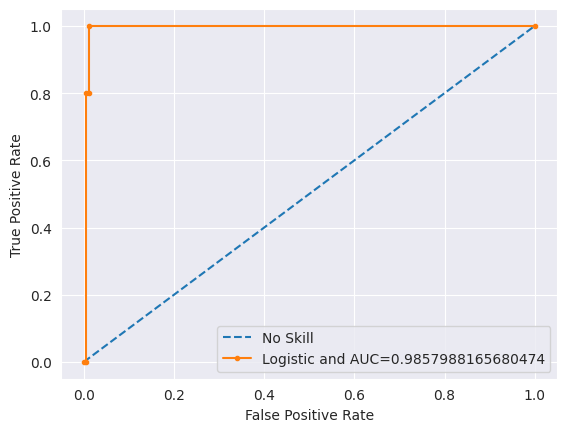

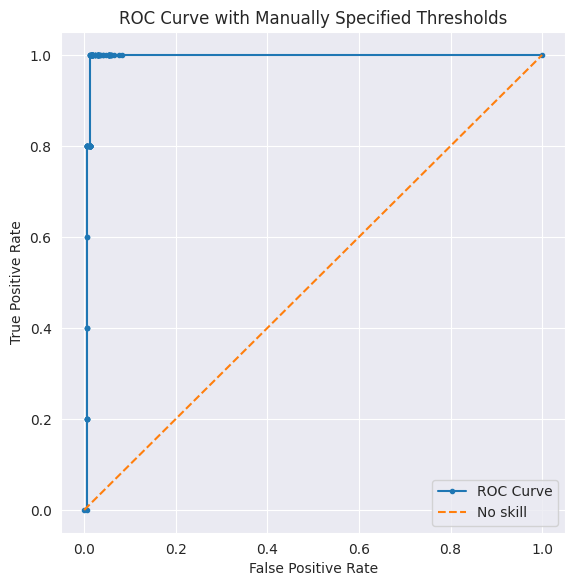

In [21]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipeline2

# a) Define the pipeline:
pipeline = Pipeline2([
    ('smote', SMOTE(random_state=123)),
    ('lasso_logistic', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])

# b) Define the parameter grid
param_grid = {
    'smote__k_neighbors': range(3,5),                       # Tuning SMOTE's k_neighbors
    'smote__sampling_strategy': np.arange(0.4, 1.1, 0.1),   # Tuning SMOTE's sampling strategy
    'lasso_logistic__C': np.arange(0.05, 2, 0.05),          # Tuning the regularization strength of Lasso
}
f1_scorer = make_scorer(f1_score)

# c) Tuning parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, refit=False, n_jobs=-1, error_score='raise')
result_tuning = grid_search.fit(x_train, y_train)
# check value of hyperparameters:
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
#print(result_tuning.best_params_)
tuned_par = list(result_tuning.best_params_.values())
print(f"SMOTE k neighbors: {tuned_par[1]}")
print(f"Imbalance ratio: {tuned_par[2]}")
print(f"Logistic C: {tuned_par[0]}")

# d) apply SMOTE and fit logistic with tuned parameters
smote_tuned = SMOTE(sampling_strategy=tuned_par[2], k_neighbors=tuned_par[1], random_state=123)
logistic_tuned = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=tuned_par[0])
x_train_smote, y_train_smote = smote_tuned.fit_resample(x_train, y_train)
print(y_train_smote.value_counts())
log_fit = logistic_tuned.fit(x_train_smote, y_train_smote)

# e) Predict on the test set
y_prob = log_fit.predict_proba(x_test)[:, 1]    # predicted prob for positive class
y_pred = log_fit.predict(x_test)

# f) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# g) Print out the results
print("\nModel fitted:")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

coefficients = log_fit.coef_[0]
non_zero_coefficients = coefficients != 0
used_features = np.array(non_zero_coefficients)

print("Features used in the model:")
for i, is_used in enumerate(non_zero_coefficients):
    if is_used:
        print(f"Feature {i+1} (Coefficient: {coefficients[i]:.4f})")
    else:
        print(f"Feature {i+1} (Coefficient: {coefficients[i]:.4f})")

# h) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic and AUC='+str(correct_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [22]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

6
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### a3) ADASYN rebalanced dataset:

Tuning parameter:
F1 score max: 0.5
ADASYN n neighbors: 3
Imbalance ratio: 0.4
Logistic C: 0.15000000000000002
Criticality_mode
0    399
1    161
Name: count, dtype: int64

Model fitted:
F1 Score: 0.769231
Sensitivity (Recall): 1.000000
Specificity: 0.982249
AUC: 0.985799
Features used in the model:
Feature 1 (Coefficient: 0.0048)
Feature 2 (Coefficient: -0.0250)
Feature 3 (Coefficient: 0.0000)
Feature 4 (Coefficient: 0.0000)
Feature 5 (Coefficient: 0.0000)
Feature 6 (Coefficient: 0.0369)
Feature 7 (Coefficient: -0.3852)
Feature 8 (Coefficient: 0.3702)
Feature 9 (Coefficient: 0.0016)
Feature 10 (Coefficient: -0.0226)
Feature 11 (Coefficient: 0.0000)


/opt/tljh/user/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


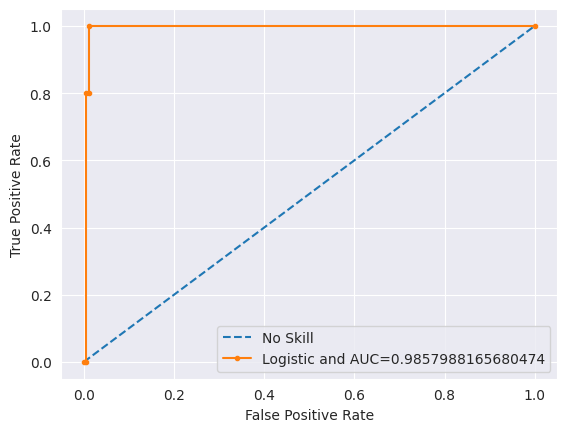

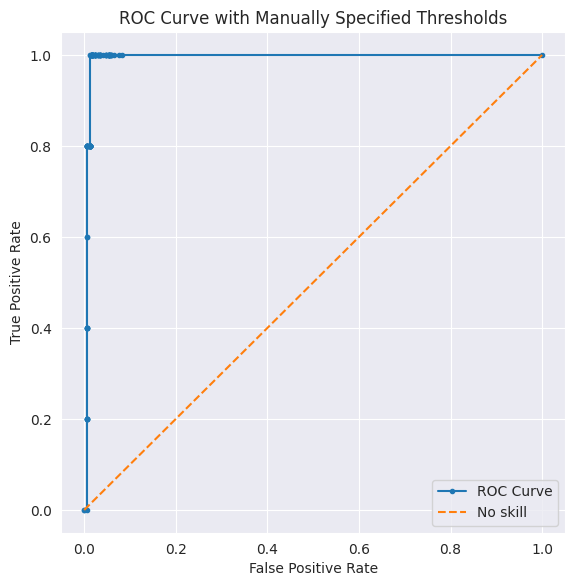

In [23]:
from imblearn.over_sampling import ADASYN

# a) Define the pipeline:
pipeline = Pipeline2([
    ('adasyn', ADASYN(random_state=123)),
    ('lasso_logistic', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])

# b) Define the parameter grid
param_grid = {
    'adasyn__n_neighbors': range(3,5),                       # Tuning ADASYN's k_neighbors
    'adasyn__sampling_strategy': np.arange(0.4, 1.1, 0.1),   # Tuning ADASYN's sampling strategy
    'lasso_logistic__C': np.arange(0.05, 2, 0.05),           # Tuning the regularization strength of Lasso
}
f1_scorer = make_scorer(f1_score)

# c) Tuning parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, refit=False, n_jobs=-1, error_score='raise')
result_tuning = grid_search.fit(x_train, y_train)
# check value of hyperparameters:
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
#print(result_tuning.best_params_)
tuned_par = list(result_tuning.best_params_.values())
print(f"ADASYN n neighbors: {tuned_par[0]}")
print(f"Imbalance ratio: {tuned_par[1]}")
print(f"Logistic C: {tuned_par[2]}")

# d) apply ADASYN and fit logistic with tuned parameters
adasyn_tuned = ADASYN(sampling_strategy=tuned_par[1], n_neighbors=tuned_par[0], random_state=123)
logistic_tuned = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=tuned_par[2])
x_train_adasyn, y_train_adasyn = adasyn_tuned.fit_resample(x_train, y_train)
print(y_train_adasyn.value_counts())
log_fit = logistic_tuned.fit(x_train_adasyn, y_train_adasyn)

# e) Predict on the test set
y_prob = log_fit.predict_proba(x_test)[:, 1]    # predicted prob for positive class
y_pred = log_fit.predict(x_test)

# f) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# g) Print out the results
print("\nModel fitted:")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

coefficients = log_fit.coef_[0]
non_zero_coefficients = coefficients != 0
used_features = np.array(non_zero_coefficients)

print("Features used in the model:")
for i, is_used in enumerate(non_zero_coefficients):
    if is_used:
        print(f"Feature {i+1} (Coefficient: {coefficients[i]:.4f})")
    else:
        print(f"Feature {i+1} (Coefficient: {coefficients[i]:.4f})")

# h) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic and AUC='+str(correct_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [24]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

6
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### a4) Moving threshold:

/home/jupyter-giulia/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Tuning parameter:
F1 score max: 0.76
C: 0.1

Model fitted:
Best threshold: 0.20400000000000001
F1 Score: 0.800000
Sensitivity (Recall): 0.800000
Specificity: 0.994083
AUC: 0.985799
Features used in the model:
Feature 1 (Coefficient: 0.0100)
Feature 2 (Coefficient: -0.0090)
Feature 3 (Coefficient: 0.0000)
Feature 4 (Coefficient: 0.0000)
Feature 5 (Coefficient: 0.0000)
Feature 6 (Coefficient: 0.0000)
Feature 7 (Coefficient: -0.1326)
Feature 8 (Coefficient: 0.1195)
Feature 9 (Coefficient: -0.0007)
Feature 10 (Coefficient: 0.0000)
Feature 11 (Coefficient: -0.0989)


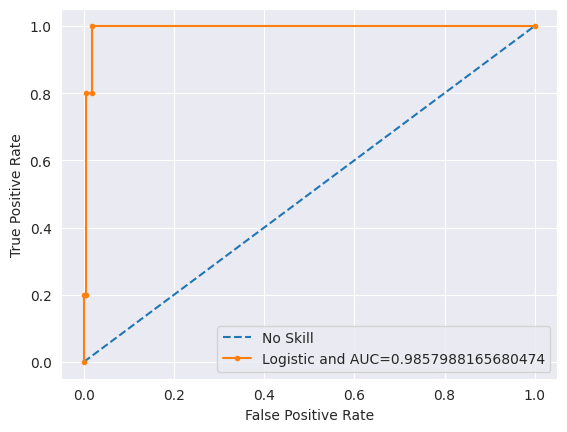

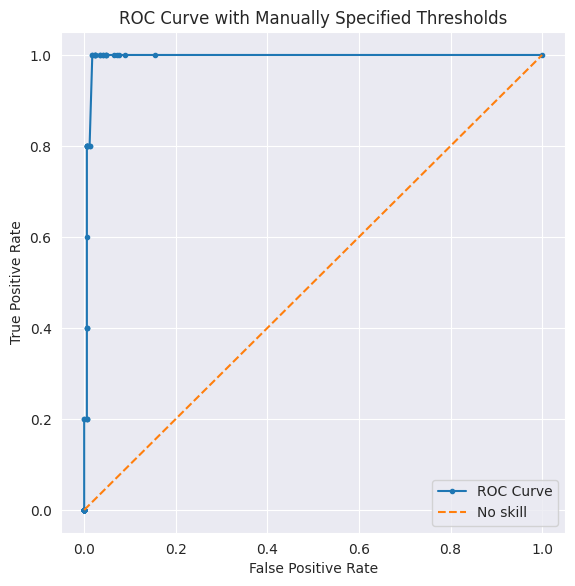

In [25]:
# a) Define a custom scoring function to optimize the threshold during grid search
def threshold_f1_scorer(y_true, y_probs):
    thresholds = np.arange(0, 1, 0.001)
    scores = [f1_score(y_true, (y_probs >= t).astype(int)) for t in thresholds]
    best_score = max(scores)
    return best_score

# b) Define the parameter grid for GridSearchCV
param_grid = {
    'C': np.arange(0.05, 2, 0.05)  # Tuning C for Lasso Logistic Regression
}

logistic = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# c) Grid search with the custom scoring function
grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring=make_scorer(threshold_f1_scorer, needs_proba=True), n_jobs=-1)
result_tuning = grid_search.fit(x_train, y_train)
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
#print(result_tuning.best_params_)
tuned_par = list(result_tuning.best_params_.values())
print(f"C: {tuned_par[0]}")

# d) fit logistic with tuned parameters
logistic_tuned = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=tuned_par[0])
log_fit = logistic_tuned.fit(x_train, y_train)

# e) Find the best threshold on the test set
y_prob = log_fit.predict_proba(x_test)[:, 1]
thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(scores)]
test_f1 = max(scores)

# f) Predict on the test set
y_pred = (y_prob >= best_threshold).astype(int)

# g) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# h) Print out the results
print("\nModel fitted:")
print(f"Best threshold: {best_threshold}")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

coefficients = log_fit.coef_[0]
non_zero_coefficients = coefficients != 0
used_features = np.array(non_zero_coefficients)

print("Features used in the model:")
for i, is_used in enumerate(non_zero_coefficients):
    if is_used:
        print(f"Feature {i+1} (Coefficient: {coefficients[i]:.4f})")
    else:
        print(f"Feature {i+1} (Coefficient: {coefficients[i]:.4f})")

# i) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic and AUC='+str(correct_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [26]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

7
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### b) KNN

K-nearest neighbors is fitted and:
- parameter "k" is tuned
- different "weights" type and "metric" type are evaluated

In [27]:
from sklearn.neighbors import KNeighborsClassifier

#### b1) Imbalanced dataset:

Tuning parameter:
F1 score max: 0.0
{'n_neighbors': 1, 'weights': 'uniform'}
k: 1
weight: uniform

Model fitted:
F1 Score: 0.000000
Sensitivity (Recall): 0.000000
Specificity: 0.982249
AUC: -0.017751


/opt/tljh/user/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


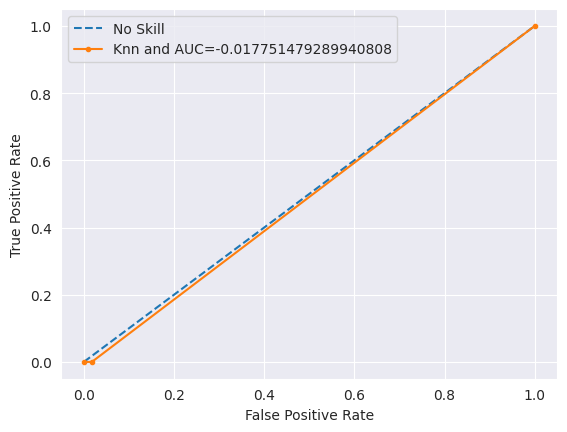

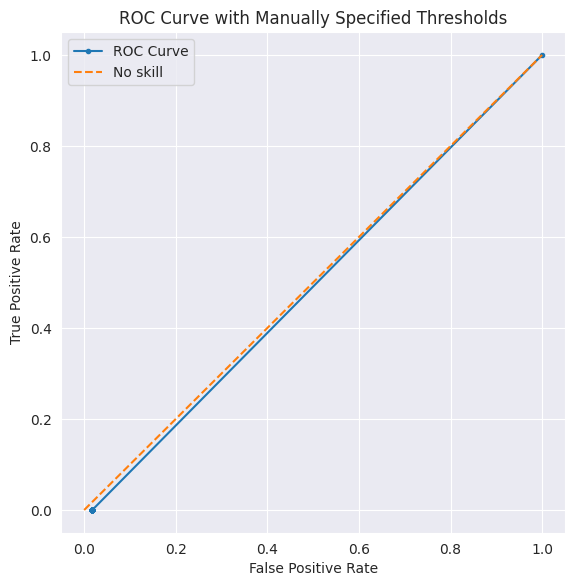

In [28]:
# a) Define the knn classifier
knn = KNeighborsClassifier()

# b) Define the parameter grid 
param_grid = {
    'n_neighbors': np.arange(1,26,1),               # Number of neighbors to try
    'weights': ['uniform', 'distance'],             # Weights for neighbors
}
# and use F1 score as metric for tuning
f1_scorer = make_scorer(f1_score)

# c) Perform GridSearchCV to find the best parameter based on F1 score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1, refit=False)
result_tuning = grid_search.fit(x_train_sd, y_train)
# check value of f1 score and C:
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
print(result_tuning.best_params_)
tuned_par = list(result_tuning.best_params_.values())
print(f"k: {tuned_par[0]}")
print(f"weight: {tuned_par[1]}")

# d) fit knn with tuned parameter
knn_tuned = KNeighborsClassifier(n_neighbors=tuned_par[0], weights=tuned_par[1])
knn_fit = knn_tuned.fit(x_train_sd, y_train)

# e) Predict on the test set
y_prob = knn_fit.predict_proba(x_test_sd)[:, 1]    # predicted prob for positive class
y_pred = knn_fit.predict(x_test_sd)

# f) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# g) Print out the results
print("\nModel fitted:")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

# h) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Knn and AUC='+str(correct_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [29]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

3
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### b2) SMOTE rebalanced dataset:

Tuning parameter:
F1 score max: 0.1
{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'smote__k_neighbors': 4, 'smote__sampling_strategy': 0.7999999999999999}
SMOTE k neighbors: 4
Imbalance ratio: 0.7999999999999999
k: 1
weight: uniform
Criticality_mode
0    399
1    319
Name: count, dtype: int64

Model fitted:
F1 Score: 0.153846
Sensitivity (Recall): 0.200000
Specificity: 0.958580
AUC: 0.158580


/opt/tljh/user/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


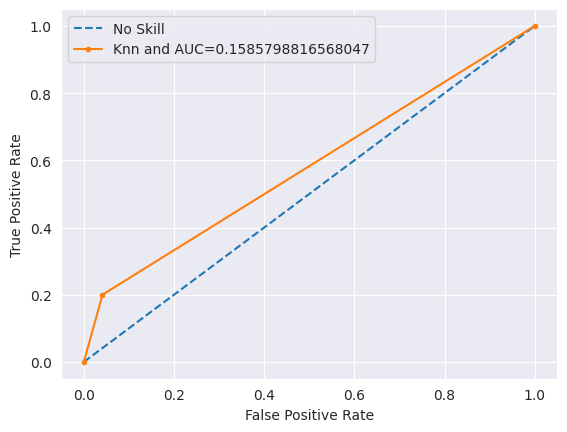

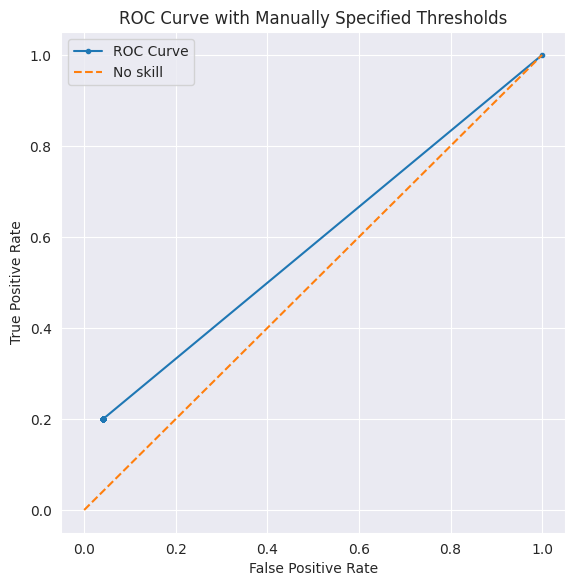

In [30]:
# a) Define the pipeline:
pipeline = Pipeline2([
    ('smote', SMOTE(random_state=123)),
    ('knn', KNeighborsClassifier())
])

# b) Define the parameter grid
param_grid = {
    'smote__k_neighbors': range(3,5),
    'smote__sampling_strategy': np.arange(0.4, 1.1, 0.1),
    'knn__n_neighbors': np.arange(1,26,1),
    'knn__weights': ['uniform', 'distance'],
}
f1_scorer = make_scorer(f1_score)

# c) Tuning parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, refit=False, n_jobs=-1, error_score='raise')
result_tuning = grid_search.fit(x_train_sd, y_train)
# check value of hyperparameters:
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
print(result_tuning.best_params_)
tuned_par = list(result_tuning.best_params_.values())
print(f"SMOTE k neighbors: {tuned_par[2]}")
print(f"Imbalance ratio: {tuned_par[3]}")
print(f"k: {tuned_par[0]}")
print(f"weight: {tuned_par[1]}")

# d) apply SMOTE and fit knn with tuned parameters
smote_tuned = SMOTE(sampling_strategy=tuned_par[3], k_neighbors=tuned_par[2], random_state=123)
knn_tuned = KNeighborsClassifier(n_neighbors=tuned_par[0], weights=tuned_par[1])
x_train_sd_smote, y_train_smote = smote_tuned.fit_resample(x_train_sd, y_train)
print(y_train_smote.value_counts())
knn_fit = knn_tuned.fit(x_train_sd_smote, y_train_smote)

# e) Predict on the test set
y_prob = knn_fit.predict_proba(x_test_sd)[:, 1]    # predicted prob for positive class
y_pred = knn_fit.predict(x_test_sd)

# f) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# g) Print out the results
print("\nModel fitted:")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

# h) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Knn and AUC='+str(correct_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [31]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

3
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### b3) ADASYN rebalanced dataset:

Tuning parameter:
F1 score max: 0.1
{'adasyn__n_neighbors': 4, 'adasyn__sampling_strategy': 0.4, 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
ADASYN n neighbors: 4
Imbalance ratio: 0.4
k: 2
weight: uniform
Criticality_mode
0    399
1    161
Name: count, dtype: int64

Model fitted:
F1 Score: 0.588235
Sensitivity (Recall): 1.000000
Specificity: 0.958580
AUC: 0.988166


/opt/tljh/user/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


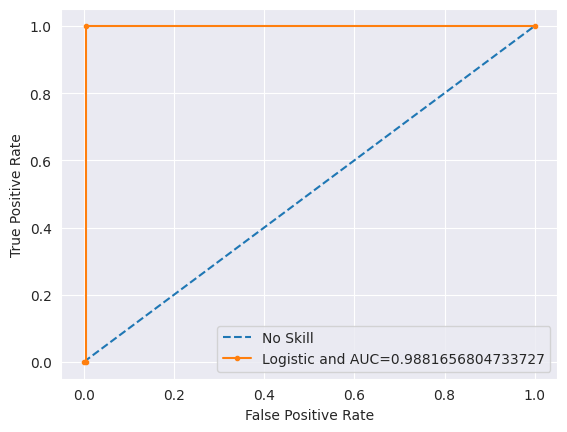

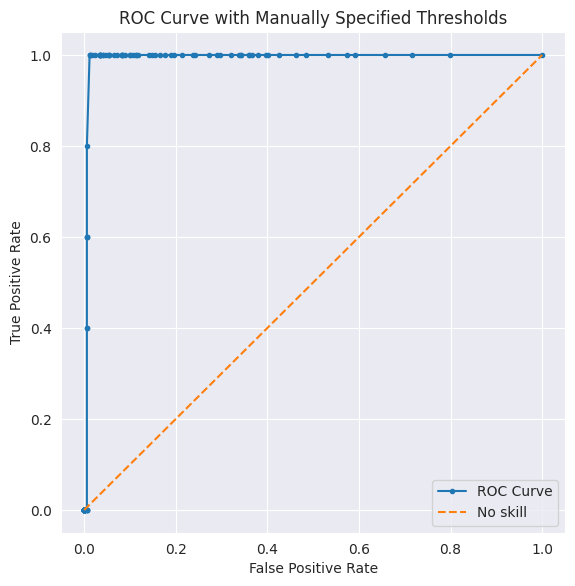

In [32]:
# a) Define the pipeline:
pipeline = Pipeline2([
    ('adasyn', ADASYN(random_state=123)),
    ('knn', KNeighborsClassifier())
])

# b) Define the parameter grid
param_grid = {
    'adasyn__n_neighbors': range(3,5),
    'adasyn__sampling_strategy': np.arange(0.4, 1.1, 0.1),
    'knn__n_neighbors': np.arange(1,26,1),
    'knn__weights': ['uniform', 'distance'],
}
f1_scorer = make_scorer(f1_score)

# c) Tuning parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, refit=False, n_jobs=-1, error_score='raise')
result_tuning = grid_search.fit(x_train_sd, y_train)
# check value of hyperparameters:
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
print(result_tuning.best_params_)
tuned_par = list(result_tuning.best_params_.values())
print(f"ADASYN n neighbors: {tuned_par[0]}")
print(f"Imbalance ratio: {tuned_par[1]}")
print(f"k: {tuned_par[2]}")
print(f"weight: {tuned_par[3]}")

# d) apply ADASYN and fit knn with tuned parameters
adasyn_tuned = ADASYN(sampling_strategy=tuned_par[1], n_neighbors=tuned_par[0], random_state=123)
knn_tuned = KNeighborsClassifier(n_neighbors=tuned_par[2], weights=tuned_par[3])
x_train_sd_adasyn, y_train_adasyn = adasyn_tuned.fit_resample(x_train_sd, y_train)
print(y_train_adasyn.value_counts())
log_fit = logistic_tuned.fit(x_train_sd_adasyn, y_train_adasyn)

# e) Predict on the test set
y_prob = log_fit.predict_proba(x_test_sd)[:, 1]    # predicted prob for positive class
y_pred = log_fit.predict(x_test_sd)

# f) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# g) Print out the results
print("\nModel fitted:")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

# h) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic and AUC='+str(correct_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [33]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

3
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### b4) Moving threshold:

/home/jupyter-giulia/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Tuning parameter:
F1 score max: 0.08458329934469914
k: 24
weights: distance

Model fitted:
Best threshold: 0.038
F1 Score: 0.206897
Sensitivity (Recall): 0.600000
Specificity: 0.875740
AUC: 0.403550


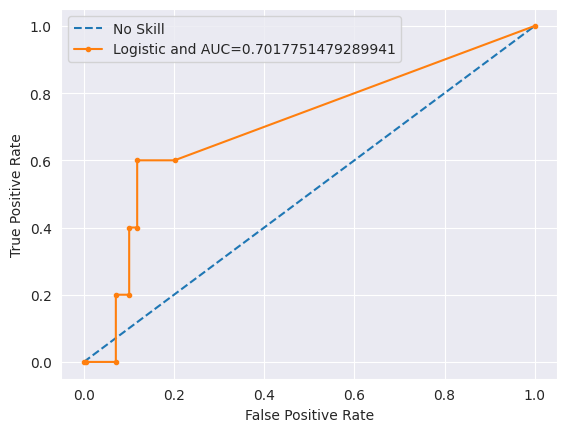

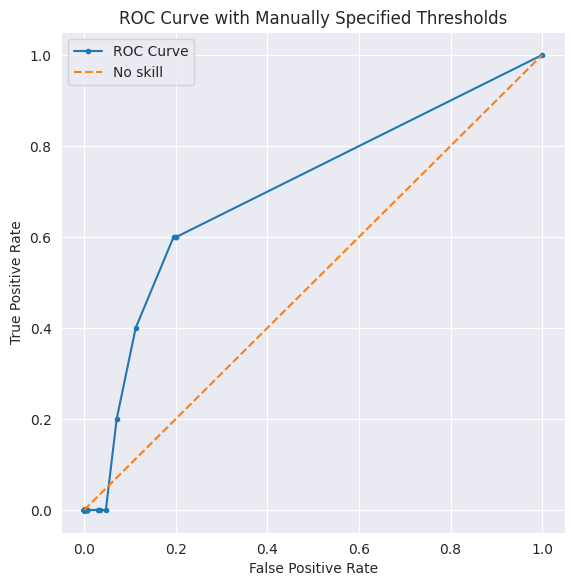

In [34]:
# a) Define a custom scoring function to optimize the threshold during grid search
def threshold_f1_scorer(y_true, y_probs):
    thresholds = np.arange(0, 1, 0.001)
    scores = [f1_score(y_true, (y_probs >= t).astype(int)) for t in thresholds]
    best_score = max(scores)
    return best_score

# b) Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': np.arange(1,26,1),
    'weights': ['uniform', 'distance'],
}

knn = KNeighborsClassifier()

# c) Grid search with the custom scoring function
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=make_scorer(threshold_f1_scorer, needs_proba=True), n_jobs=-1)
result_tuning = grid_search.fit(x_train_sd, y_train)
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
#print(result_tuning.best_params_)
tuned_par = list(result_tuning.best_params_.values())
print(f"k: {tuned_par[0]}")
print(f"weights: {tuned_par[1]}")

# d) fit knn with tuned parameters
knn_tuned = KNeighborsClassifier(n_neighbors=tuned_par[0], weights=tuned_par[1])
knn_fit = knn_tuned.fit(x_train_sd, y_train)

# e) Find the best threshold on the test set
y_prob = knn_fit.predict_proba(x_test_sd)[:, 1]
thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(scores)]
test_f1 = max(scores)

# f) Predict on the test set
y_pred = (y_prob >= best_threshold).astype(int)

# g) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# h) Print out the results
print("\nModel fitted:")
print(f"Best threshold: {best_threshold}")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

# i) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic and AUC='+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [35]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

1000
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### c) LDA

Linear Discriminant Analysis model is fitted without any tuning parameter procedure

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#### c1) Imbalanced dataset:


Model fitted:
F1 Score: 0.000000
Sensitivity (Recall): 0.000000
Specificity: 0.994083
AUC: 0.775148


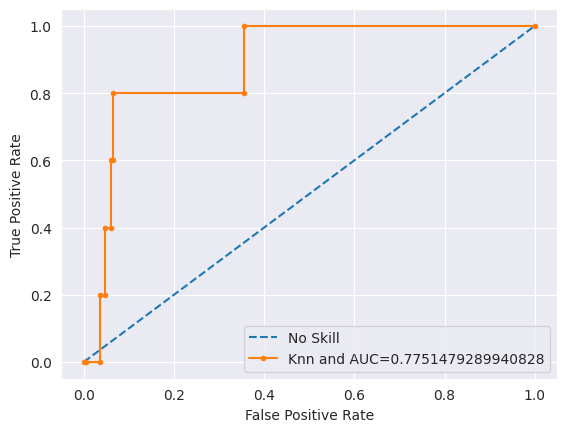

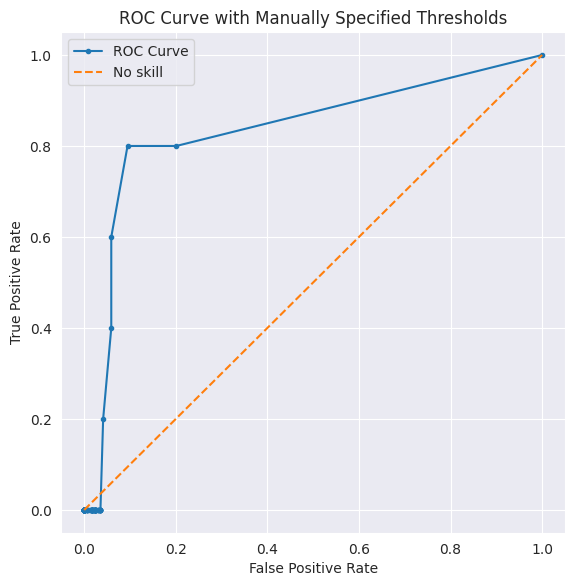

In [37]:
# a) Define the lda model with all default values setted
lda = LinearDiscriminantAnalysis()

# b) Fit the lda model
lda_fit = lda.fit(x_train_sd, y_train)

# c) Predict on the test set
y_prob = lda_fit.predict_proba(x_test_sd)[:, 1]    # predicted prob for positive class
y_pred = lda_fit.predict(x_test_sd)

# d) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# e) Print out the results
print("\nModel fitted:")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

# f) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Knn and AUC='+str(correct_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [38]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

13
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### c2) SMOTE rebalanced dataset:

Tuning parameter:
F1 score max: 0.18714285714285714
SMOTE k neighbors: 4
Imbalance ratio: 0.4
Criticality_mode
0    399
1    159
Name: count, dtype: int64

Model fitted:
F1 Score: 0.444444
Sensitivity (Recall): 0.800000
Specificity: 0.946746
AUC: 0.879290


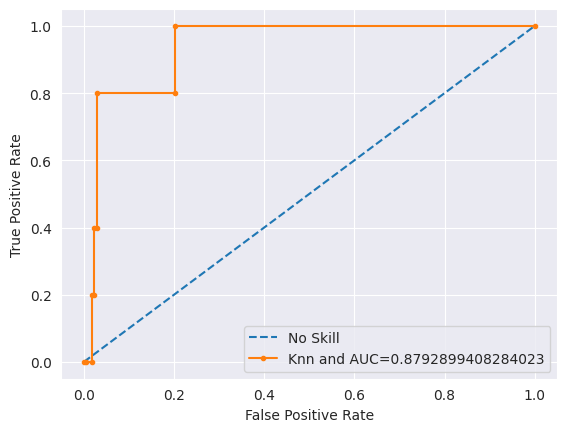

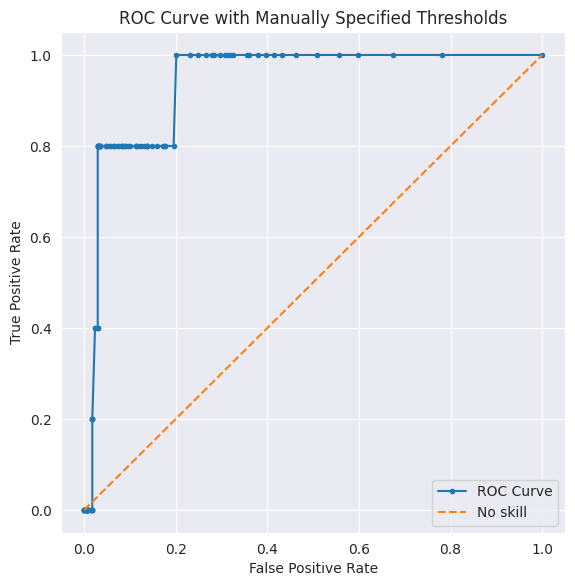

In [39]:
# a) Define the pipeline:
pipeline = Pipeline2([
    ('smote', SMOTE(random_state=123)),
    ('lda', LinearDiscriminantAnalysis())
])

# b) Define the parameter grid
param_grid = {
    'smote__k_neighbors': range(3,5),
    'smote__sampling_strategy': np.arange(0.4, 1.1, 0.1),
}
f1_scorer = make_scorer(f1_score)

# c) Tuning parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, refit=False, n_jobs=-1, error_score='raise')
result_tuning = grid_search.fit(x_train_sd, y_train)
# check value of hyperparameters:
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
#print(result_tuning.best_params_)
tuned_par = list(result_tuning.best_params_.values())
print(f"SMOTE k neighbors: {tuned_par[0]}")
print(f"Imbalance ratio: {tuned_par[1]}")

# d) Apply SMOTE and fit lda with tuned parameters
smote_tuned = SMOTE(sampling_strategy=tuned_par[1], k_neighbors=tuned_par[0], random_state=123)
x_train_sd_smote, y_train_smote = smote_tuned.fit_resample(x_train_sd, y_train)
print(y_train_smote.value_counts())
lda_fit = lda.fit(x_train_sd_smote, y_train_smote)

# e) Predict on the test set
y_prob = lda_fit.predict_proba(x_test_sd)[:, 1]    # predicted prob for positive class
y_pred = lda_fit.predict(x_test_sd)

# f) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# g) Print out the results
print("\nModel fitted:")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

# h) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Knn and AUC='+str(correct_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [40]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

13
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### c3) ADASYN rebalanced dataset:

Tuning parameter:
F1 score max: 0.18
SMOTE k neighbors: 4
Imbalance ratio: 0.4
Criticality_mode
0    399
1    161
Name: count, dtype: int64

Model fitted:
F1 Score: 0.444444
Sensitivity (Recall): 0.800000
Specificity: 0.946746
AUC: 0.815385


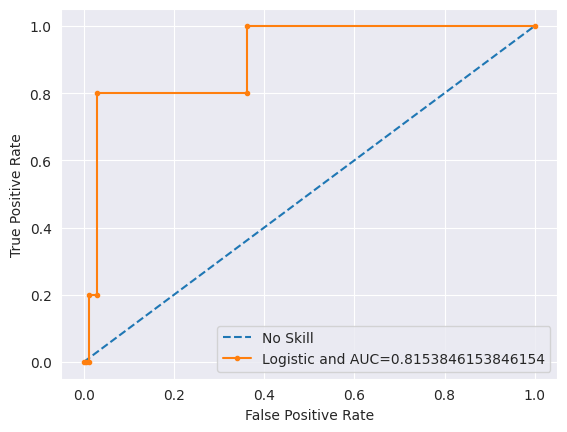

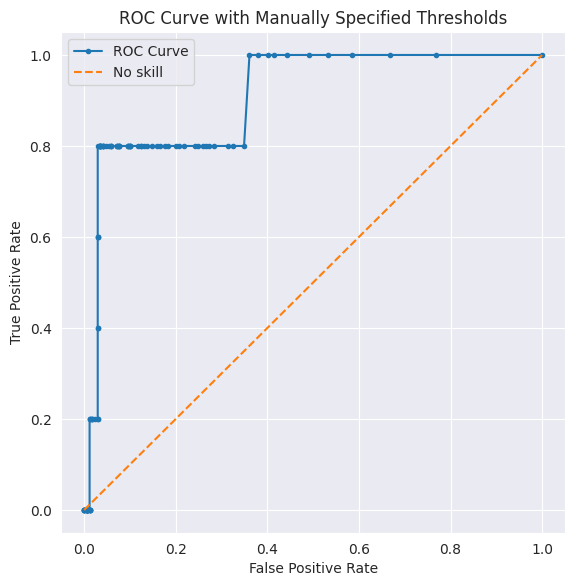

In [41]:
# a) Define the pipeline:
pipeline = Pipeline2([
    ('adasyn', ADASYN(random_state=123)),
    ('lda', LinearDiscriminantAnalysis())
])

# b) Define the parameter grid
param_grid = {
    'adasyn__n_neighbors': range(3,5),
    'adasyn__sampling_strategy': np.arange(0.4, 1.1, 0.1),
}
f1_scorer = make_scorer(f1_score)

# c) Tuning parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, refit=False, n_jobs=-1, error_score='raise')
result_tuning = grid_search.fit(x_train_sd, y_train)
# check value of hyperparameters:
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
#print(result_tuning.best_params_)
tuned_par = list(result_tuning.best_params_.values())
print(f"SMOTE k neighbors: {tuned_par[0]}")
print(f"Imbalance ratio: {tuned_par[1]}")

# d) Apply ADASYN and fit lda with tuned parameters
adasyn_tuned = ADASYN(sampling_strategy=tuned_par[1], n_neighbors=tuned_par[0], random_state=123)
x_train_sd_adasyn, y_train_adasyn = adasyn_tuned.fit_resample(x_train_sd, y_train)
print(y_train_adasyn.value_counts())
lda_fit = lda.fit(x_train_sd_adasyn, y_train_adasyn)

# e) Predict on the test set
y_prob = lda_fit.predict_proba(x_test_sd)[:, 1]    # predicted prob for positive class
y_pred = lda_fit.predict(x_test_sd)

# f) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# g) Print out the results
print("\nModel fitted:")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

# h) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic and AUC='+str(correct_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [42]:
# extra)
# a) what the function roc_curve does?
#for i, threshold in enumerate(thresholds):
    #print(f"Threshold: {threshold:.4f}, TPR: {tpr[i]:.4f}, FPR: {fpr[i]:.4f}")

print(len(thresholds))

# b) manually computed:
print(f'Number of thresholds: {len(thresholds_2)}')
print(f'Number of FPR values: {len(fprs)}')
print(f'Number of TPR values: {len(tprs)}')
#print('Thresholds:', thresholds_2)
#print('FPRs:', fprs)
#print('TPRs:', tprs)

13
Number of thresholds: 101
Number of FPR values: 101
Number of TPR values: 101


#### c4) Moving threshold:


Model fitted:
Best threshold: 0.023
F1 Score: 0.400000
Sensitivity (Recall): 0.800000
Specificity: 0.934911
AUC: 0.775148


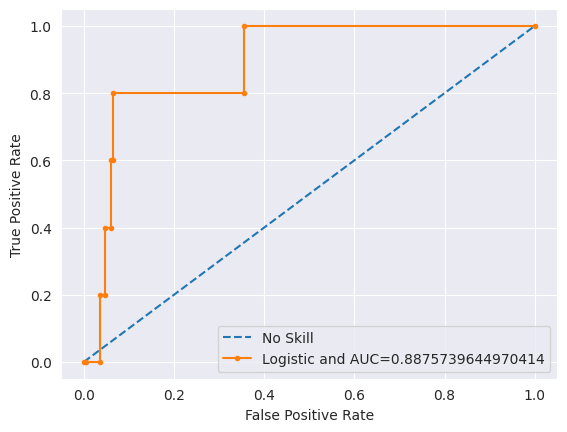

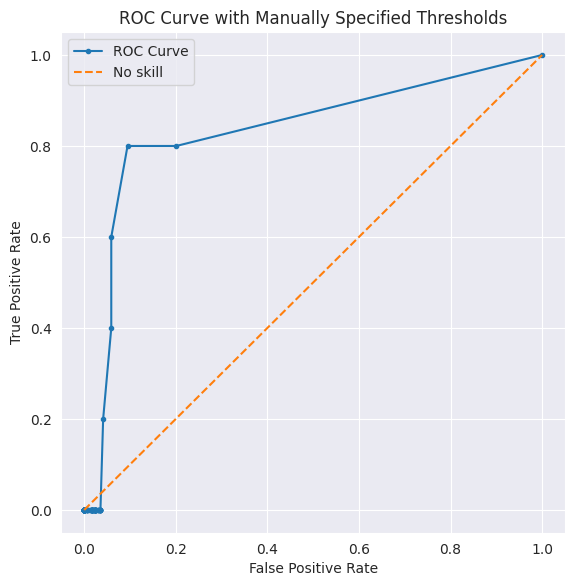

In [43]:
# a) Define a custom scoring function to optimize the threshold during grid search
def threshold_f1_scorer(y_true, y_probs):
    thresholds = np.arange(0, 1, 0.001)
    scores = [f1_score(y_true, (y_probs >= t).astype(int)) for t in thresholds]
    best_score = max(scores)
    return best_score

# b) Define the lda model with all default values setted
lda = LinearDiscriminantAnalysis()

# c) Fit the lda model
lda_fit = lda.fit(x_train_sd, y_train)

# e) Find the best threshold on the test set
y_prob = lda_fit.predict_proba(x_test_sd)[:, 1]
thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(scores)]
test_f1 = max(scores)

# f) Predict on the test set
y_pred = (y_prob >= best_threshold).astype(int)

# g) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# h) Print out the results
print("\nModel fitted:")
print(f"Best threshold: {best_threshold}")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
correct_auc = (auc-0.5)/0.5
print(f"AUC: {correct_auc:.6f}")

# i) Plot roc curve:
# generate a no skill prediction (majority class)
ns_y_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_y_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_y_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic and AUC='+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

thresholds_2 = np.arange(0.0, 1.01, 0.01)
fprs = []
tprs = []
for threshold_2 in thresholds_2:
    y_pred = (y_prob >= threshold_2).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_2 = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
    fprs.append(fpr_2)
    tprs.append(tpr_2)
plt.figure(figsize=(6.5, 6.5))
plt.plot(fprs, tprs, marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Manually Specified Thresholds')
plt.legend()
plt.show()

In [44]:
'''
# 4) MOVING THRESHOLD:
from sklearn.base import BaseEstimator, ClassifierMixin

# a) Define functions
# Custom classifier that allows for threshold adjustment
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator=None, threshold=0.5):
        self.estimator = estimator
        self.threshold = threshold

    def fit(self, X, y):
        self.estimator.fit(X, y)
        self.classes_ = self.estimator.classes_
        return self

    def predict(self, X):
        proba = self.estimator.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def get_params(self, deep=True):
        return {
            'estimator': self.estimator,
            'threshold': self.threshold
        }

    def set_params(self, **params):
        if 'estimator' in params:
            self.estimator = params.pop('estimator')
        if 'threshold' in params:
            self.threshold = params.pop('threshold')
        return self

logistic = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# b) Define parameter grid
param_grid = {
    'estimator__C': np.arange(0.05, 2, 0.05),                # Tuning C for Lasso Logistic Regression
    'threshold': np.arange(0.05, 1.05, 0.05)         # Tuning the decision threshold
}
f1_scorer = make_scorer(f1_score)

# c) Grid search
grid_search = GridSearchCV(ThresholdClassifier(estimator=logistic), param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1, refit=False, error_score='raise')
result_tuning = grid_search.fit(x_train, y_train)
# check value of hyperparameters:
print("Tuning parameter:")
print(f"F1 score max: {result_tuning.best_score_}")
#print(result_tuning.best_params_)
tuned_par = list(result_tuning.best_params_.values())
print(f"C: {tuned_par[0]}")
print(f"Threshold: {tuned_par[1]}")

# d) fit logistic with tuned parameters
logistic_tuned = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=tuned_par[0])
log_fit = logistic_tuned.fit(x_train, y_train)

# e) Predict on the test set
# Define a function to apply a custom threshold
def apply_threshold(proba, threshold=0.5):
    return (proba >= threshold).astype(int)

y_prob = log_fit.predict_proba(x_test)[:, 1]    # predicted prob for positive class
y_pred = apply_threshold(y_prob, threshold=tuned_par[1])

# f) Calculate performance metrics: f1 score, sensitivity, specificity, auc
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# g) Print out the results
print("\nModel fitted:")
print(f"F1 Score: {f1:.6f}")
print(f"Sensitivity (Recall): {sensitivity:.6f}")
print(f"Specificity: {specificity:.6f}")
print(f"AUC: {auc:.6f}")

coefficients = log_fit.coef_[0]
non_zero_coefficients = coefficients != 0
used_features = np.array(non_zero_coefficients)

print("Features used in the model:")
for i, is_used in enumerate(non_zero_coefficients):
    if is_used:
        print(f"Feature {i+1} (Coefficient: {coefficients[i]:.4f})")
    else:
        print(f"Feature {i+1} (Coefficient: {coefficients[i]:.4f})")

# h) Plot roc curve:
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
'''

'\n# 4) MOVING THRESHOLD:\nfrom sklearn.base import BaseEstimator, ClassifierMixin\n\n# a) Define functions\n# Custom classifier that allows for threshold adjustment\nclass ThresholdClassifier(BaseEstimator, ClassifierMixin):\n    def __init__(self, estimator=None, threshold=0.5):\n        self.estimator = estimator\n        self.threshold = threshold\n\n    def fit(self, X, y):\n        self.estimator.fit(X, y)\n        self.classes_ = self.estimator.classes_\n        return self\n\n    def predict(self, X):\n        proba = self.estimator.predict_proba(X)[:, 1]\n        return (proba >= self.threshold).astype(int)\n\n    def predict_proba(self, X):\n        return self.estimator.predict_proba(X)\n\n    def get_params(self, deep=True):\n        return {\n            \'estimator\': self.estimator,\n            \'threshold\': self.threshold\n        }\n\n    def set_params(self, **params):\n        if \'estimator\' in params:\n            self.estimator = params.pop(\'estimator\')\n    

In [45]:
'''
# single logistic regression for each predictor:
#!pip install scikit-learn
from sklearn.linear_model import LogisticRegression

# a) define predictors and dependent variable:
x = data.drop('Criticality_mode', axis=1)
y = data['Criticality_mode']

# b) instantiate the model:
logreg = LogisticRegression(penalty=None,
                            class_weight='balanced',    #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
                            solver='newton-cholesky',   #‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix
                            )
'''

"\n# single logistic regression for each predictor:\n#!pip install scikit-learn\nfrom sklearn.linear_model import LogisticRegression\n\n# a) define predictors and dependent variable:\nx = data.drop('Criticality_mode', axis=1)\ny = data['Criticality_mode']\n\n# b) instantiate the model:\nlogreg = LogisticRegression(penalty=None,\n                            class_weight='balanced',    #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))\n                            solver='newton-cholesky',   #‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix\n                            )\n"

In [46]:
'''
# c) encoding categorical variables as k-1 dummy variables (k=n. of classes):
# first of all categorical variables need to be preprocessed because scikitlearn handles categorical features only if encoded as k dummy variables:
print(x_cat)
for i in x_cat:
       print(data[i].value_counts())

data_encoded = pd.get_dummies(data, columns=['Source_mode', 'Colour_mode', 'Season'], drop_first=True)
data_encoded2 = pd.get_dummies(data_encoded, columns=['Name_mode'])
print(data_encoded2.info())
data_encoded3 = data_encoded2.drop(columns=['Name_mode_710-000', 'Name_mode_710-131'])
print(data_encoded3.info())

enc_var = data_encoded3.columns[19:29]
print(enc_var)

for i in enc_var:
       data_encoded3[i] = data_encoded3[i].astype('int64')

data_encoded3['Criticality_mode'] = data_encoded3['Criticality_mode'].astype('int64')
print(data_encoded3.info())
'''

"\n# c) encoding categorical variables as k-1 dummy variables (k=n. of classes):\n# first of all categorical variables need to be preprocessed because scikitlearn handles categorical features only if encoded as k dummy variables:\nprint(x_cat)\nfor i in x_cat:\n       print(data[i].value_counts())\n\ndata_encoded = pd.get_dummies(data, columns=['Source_mode', 'Colour_mode', 'Season'], drop_first=True)\ndata_encoded2 = pd.get_dummies(data_encoded, columns=['Name_mode'])\nprint(data_encoded2.info())\ndata_encoded3 = data_encoded2.drop(columns=['Name_mode_710-000', 'Name_mode_710-131'])\nprint(data_encoded3.info())\n\nenc_var = data_encoded3.columns[19:29]\nprint(enc_var)\n\nfor i in enc_var:\n       data_encoded3[i] = data_encoded3[i].astype('int64')\n\ndata_encoded3['Criticality_mode'] = data_encoded3['Criticality_mode'].astype('int64')\nprint(data_encoded3.info())\n"

In [47]:
'''
x = data_encoded3[['Source_711-083']]
y = data_encoded3['Criticality_mode']
try1 = logreg.fit(x, y)
print(try1.coef_)

#!pip install statsmodels
import statsmodels.api as sm
log_reg = sm.Logit(y, x).fit()
print(log_reg.summary())
print(log_reg.pvalues)      # H0: population coefficient is zero
'''

"\nx = data_encoded3[['Source_711-083']]\ny = data_encoded3['Criticality_mode']\ntry1 = logreg.fit(x, y)\nprint(try1.coef_)\n\n#!pip install statsmodels\nimport statsmodels.api as sm\nlog_reg = sm.Logit(y, x).fit()\nprint(log_reg.summary())\nprint(log_reg.pvalues)      # H0: population coefficient is zero\n"

In [48]:
'''
log_reg = sm.Logit(data['Criticality_mode'], data['Source_mode']).fit()
print(log_reg.summary())
print(log_reg.pvalues)
'''

"\nlog_reg = sm.Logit(data['Criticality_mode'], data['Source_mode']).fit()\nprint(log_reg.summary())\nprint(log_reg.pvalues)\n"

In [49]:
'''

# d) fit the model:

x = data_encoded3.drop('Criticality_mode', axis=1)
y = data_encoded3['Criticality_mode']

for predictor in x:
       logreg.fit(predictor, y)
'''

"\n\n# d) fit the model:\n\nx = data_encoded3.drop('Criticality_mode', axis=1)\ny = data_encoded3['Criticality_mode']\n\nfor predictor in x:\n       logreg.fit(predictor, y)\n"

In [50]:
# da scartare

'''
# Y and numerical predictors:
x_num_1 = ['Source_711-083', 'Source_711-084', 'Name_710-131', 'Name_710-132', 'Name_710-135', 'Name_710-170',
       'Name_711-083', 'Name_711-084']
x_num_2 = ['Type_PDM', 'Type_TRAIN_DRIVER', 'Type_WARNING', 'Speed_mean', 'Colour_azzurro', 'Colour_giallo']
x_num_3 = ['Services', 'Total_KM', 'Sched_maint_progr', 'Corr_maint_progr']
x_num = ['Source_711-083', 'Source_711-084', 'Name_710-131', 'Name_710-132', 'Name_710-135', 'Name_710-170',
       'Name_711-083', 'Name_711-084', 'Type_PDM', 'Type_TRAIN_DRIVER', 'Type_WARNING', 'Speed_mean', 'Colour_azzurro', 'Colour_giallo',
       'Services', 'Total_KM', 'Sched_maint_progr', 'Corr_maint_progr']
# 1)
sns.pairplot(data, vars=x_num_1, hue='Criticality_mode')
sns.pairplot(data, vars=x_num_2, hue='Criticality_mode')
sns.pairplot(data, vars=x_num_3, hue='Criticality_mode')
'''

"\n# Y and numerical predictors:\nx_num_1 = ['Source_711-083', 'Source_711-084', 'Name_710-131', 'Name_710-132', 'Name_710-135', 'Name_710-170',\n       'Name_711-083', 'Name_711-084']\nx_num_2 = ['Type_PDM', 'Type_TRAIN_DRIVER', 'Type_WARNING', 'Speed_mean', 'Colour_azzurro', 'Colour_giallo']\nx_num_3 = ['Services', 'Total_KM', 'Sched_maint_progr', 'Corr_maint_progr']\nx_num = ['Source_711-083', 'Source_711-084', 'Name_710-131', 'Name_710-132', 'Name_710-135', 'Name_710-170',\n       'Name_711-083', 'Name_711-084', 'Type_PDM', 'Type_TRAIN_DRIVER', 'Type_WARNING', 'Speed_mean', 'Colour_azzurro', 'Colour_giallo',\n       'Services', 'Total_KM', 'Sched_maint_progr', 'Corr_maint_progr']\n# 1)\nsns.pairplot(data, vars=x_num_1, hue='Criticality_mode')\nsns.pairplot(data, vars=x_num_2, hue='Criticality_mode')\nsns.pairplot(data, vars=x_num_3, hue='Criticality_mode')\n"